# Machine learning with the photosynthesis database
This began as an exlporation of morphological data associated with CAM in 163 bromeliad species ([Males 2018](http://www.publish.csiro.au/FP/FP17071)), but has snowballed into a [dataset of photosynthesis-associated morphological and physiological measurements](https://github.com/isgilman/photo_db) with a small accompanying package called `photo_db` which allows users to access the database and do a few simple, useful manipulations to the data. Below I'll walk through importing the data, visualizing it with a few features of `photo_db`, and then show how these data can be used to classify a plant's photosynthetic pathway using morphological data.

I originally thought to apply machine learning techniques (specifically linear classifiers like support vector machines and random forests) to the bromeliad data because scatter plots of the raw data seemed to show clear break between C3 and CAM species, but projecting the data into PC space eroded these patterns. Below I show that the most extreme phenotypes&mdash;C3 and CAM&mdash;are relatively easily classified in bromeliads using only the following morphological measurements:

* chlorenchyma cell diameter
* chlorenchyma vertical thickness
* leaf thickness
* hydrenchyma vertical thickness
* air channel area.

Although this is a big success, these morphological measurements are about as easy to collect as $\delta C^{13}$ isotope measurements that we already know can distinguish these phenotypes. The real challege is to use morphology to classify C3-CAM species, which may or may not show the hallmark isotope signature of CAM species. The bromeliad data do not contain enough instances of these phenotypes for classification, so I turn to a study of 173 orchid species ([Silvera et al. 2005](http://www.publish.csiro.au/FP/FP04179)) that spans the CAM-spectrum with relatively equal abundances. Unfortunately, these data only contain three morphological features and the small size means that each category has about half of the observations as in the bromeliad data, so our power to discriminate between them is reduced.

I will be (hopefully) constantly refining and adding analyses as I find more data or better ways to handle it. My largest problem right now is the sparsity of the CAM database matrix. Currently I'm working on different ways to impute missing data, which is what `photo_db` grew out of.

**References**
1. Males J. 2018. Concerted anatomical change associated with crassulacean acid metabolism in the Bromeliaceae. Functional Plant Biol. 45:681–695.
2. Silvera K., Santiago L.S., Winter K. 2005. Distribution of crassulacean acid metabolism in orchids of Panama: evidence of selection for weak and strong modes. Functional Plant Biol. 32:397–11.

In [1]:
# photo_db
from photo_db import photo_db
# Core
import pandas as pd
import scipy as sp
import numpy as np
# Plotting
%matplotlib inline
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
sns.set(style="ticks")
# Machine learning
import sklearn as skl
from sklearn import svm, datasets
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score

## Load data using `photo_db`
Loading the data is easy with `pull_data`. There are two sets of data that we can access:
 1. 'cam_db', which contains the morphological and physiological data, along with taxonomic metadata
 2. 'the_list', which contains the known photosynthetic pathways for all land plant genera

In [2]:
# Load data from GitHub
cam_db = photo_db.pull_data()
# A few positibe values have been sneaking in
cam_db["dC13"] = cam_db["dC13"].apply(lambda x: x if x <0 else -1.0*x)
cam_db.head()

,Family,Subfamily,Tribe,Subtribe,Genus,Species,Subspecies,BS_area_um2,FM_DM,FM_DM_sd,...,avg_elevation_m,LCCDM,SLAFM,tissue,long_name,pct_night_C02,H+_ev_mumol_g-1_DW,H+_ev_mumol_g-1_DW_sd,H+_mo_mumol_g-1_DW,H+_mo_mumol_g-1_DW_sd
0,Orchidaceae,NaN,NaN,NaN,Acineta,sp.,NaN,NaN,7.1,0.3,...,NaN,NaN,NaN,NaN,Acineta sp.,NaN,NaN,NaN,NaN,NaN
1,Orchidaceae,Epidendroideae,Cymbidieae,Oncidiinae,Ada,allenii,NaN,NaN,8.1,0.5,...,NaN,NaN,NaN,NaN,Ada allenii,NaN,NaN,NaN,NaN,NaN
2,Orchidaceae,NaN,NaN,NaN,Ancipitia,crocodiliceps,NaN,NaN,8.7,0.9,...,NaN,NaN,NaN,NaN,Ancipitia crocodiliceps,NaN,NaN,NaN,NaN,NaN
3,Orchidaceae,Epidendroideae,Arethuseae,Arethusinae,Arundina,graminifolia,NaN,NaN,3.5,0.2,...,NaN,NaN,NaN,NaN,Arundina graminifolia,NaN,NaN,NaN,NaN,NaN
4,Orchidaceae,Epidendroideae,Cymbidieae,Oncidiinae,Aspasia,epidendroides,NaN,NaN,5.3,0.2,...,NaN,NaN,NaN,NaN,Aspasia epidendroides,NaN,NaN,NaN,NaN,NaN


`photo_db` also contains some useful summary statistics and plotting methods.

In [3]:
photo_db.db_info(cam_db)

The CAM database consists of:
	5856 observations,                                            
	59 families,                                            
	12 subfamiles,                                            
	13 tribes,                                            
	22 subtribes,                                            
	447 genera, and                                            
	3762 species from 61 publications.                                            
0.828 of the data matrix is missing and                                            
785 observations have known photosynthetic pathways.


Using `drop_ambig`, we can reduce this matrix to only those accessions with recognized genera and species. We'll also remove measurements from tissue other than leaves.

In [4]:
# Drop unidentified species and genera
cam_db = photo_db.drop_ambig(cam_db, rank='Species')
cam_db = photo_db.drop_ambig(cam_db, rank='Genus')
# Drop nonleaf and stem measurements
drop_tissues = ['bract', 'flower', 'fruit wall', 'inflorescence axis','pedicel']
cam_db = cam_db[~cam_db['Tissue'].isin(drop_tissues)]
cam_db = cam_db[~cam_db['plant_part'].isin(drop_tissues)]
cam_db = cam_db[~cam_db['tissue'].isin(drop_tissues)]
cam_db.drop(labels=['Tissue', 'plant_part', 'tissue'], axis=1, inplace=True)

Now we'll use the `db_info` function to get a broad picture of our data, which incorpates missing dat plotting from the `missingno` package.

The CAM database consists of:
	5452 observations,                                            
	57 families,                                            
	12 subfamiles,                                            
	13 tribes,                                            
	22 subtribes,                                            
	433 genera, and                                            
	3549 species from 61 publications.                                            
0.823 of the data matrix is missing and                                            
760 observations have known photosynthetic pathways.


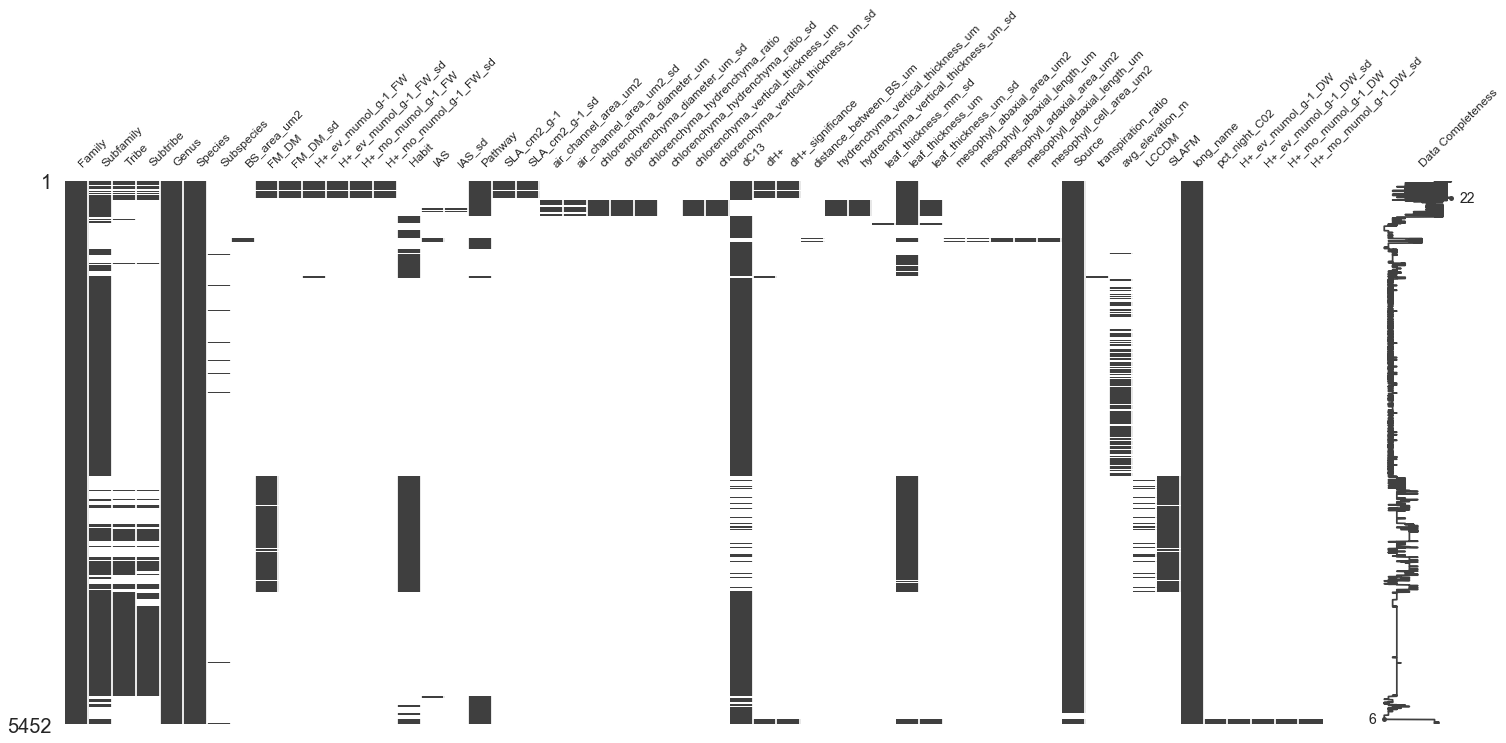

In [5]:
photo_db.db_info(cam_db=cam_db, plt_missingdata=True, labels=True, fontsize=12)

Using the missingno module we can visualize the missing data in our dataframe. Black represents measurements and white is the lack of. The squiggly line on the far right shows how many features have measurements for any one observations, which here ranges from 6 (strictly taxonomic information plus a single measurement) to 21 (taxonomy plus many measurements).

Now we'll look at an example of what we can do with these data, beginning with some visualization of the data and ended with classification of species into different types of photosynthesis using purely morphological measurements.

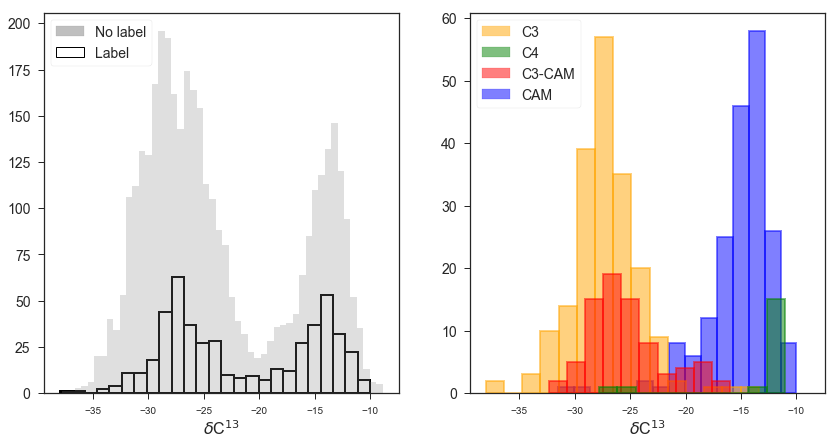

In [6]:
fig, (ax1, ax0) = plt.subplots(1, 2, figsize=(14,7), sharex=True)

ax0.hist(x=cam_db[cam_db['Pathway']=='CAM']['dC13'].dropna(), edgecolor='blue',
         linewidth=2, color='blue', alpha=0.5, bins=15)
ax0.hist(x=cam_db[cam_db['Pathway']=='C3']['dC13'].dropna(), edgecolor='orange', 
         linewidth=2, color='orange', alpha=0.5, bins=15)
ax0.hist(x=cam_db[cam_db['Pathway']=='C3-CAM']['dC13'].dropna(), edgecolor='red', 
         linewidth=2, color='red', alpha=0.5, bins=10)
ax0.hist(x=cam_db[cam_db['Pathway']=='C4']['dC13'].dropna(), edgecolor='green', 
         linewidth=2, color='green', alpha=0.5, bins=10)

ax1.hist(x=cam_db[cam_db['Pathway'].isin(['C3', 'C4', 'CAM', 'C3-CAM', 'C3-C4'])]['dC13'].dropna(), 
         fc=(1, 1, 1, 1), edgecolor='black', linewidth=2, alpha=1, bins=25)
ax1.hist(x=cam_db[cam_db['Pathway'].isnull()]['dC13'].dropna(), color='grey', alpha=0.25, bins=50)

orange_patch = mpatches.Patch(color='orange', alpha=0.5, label='C3', )
green_patch = mpatches.Patch(color='green', alpha=0.5, label='C4')
red_patch = mpatches.Patch(color='red', alpha=0.5, label='C3-CAM')
blue_patch = mpatches.Patch(color='blue', alpha=0.5, label='CAM')

ax0.legend(handles=[orange_patch, green_patch, red_patch, blue_patch], fontsize=14, frameon=True, )
ax0.set_xlabel('$\delta$C$^{13}$', size=16)
ax0.tick_params(axis='y', which='major', labelsize=14)

grey_patch = mpatches.Patch(color='grey', alpha=0.5, label='No label')
black_patch = mpatches.Patch(facecolor='white', edgecolor='black', linewidth=1, label='Label')

ax1.legend(handles=[grey_patch, black_patch], fontsize=14, frameon=True, loc='upper left')
ax1.set_xlabel('$\delta$C$^{13}$', size=16)
ax1.tick_params(axis='y', which='major', labelsize=14);
# Save figure
# plt.savefig('/GitHub/photo_db/images/dC13_hist.pdf', format='pdf', transparent=True, dpi=300);

In the carbon isotope histograms above we see both the characteristic bimodal distribution that separates C3 and CAM, and that the majority of measurements don't have a pathway listed. We can impute data based on information from closely related taxa by using the `fill_na_modes` function. Although Pandas provides a bunch of different ways to fill missing data (e.g. first, last, average), it does not offer a mode method, which we need to impute categorical values. Below we'll first impute the mode of `cam_db['Pathway]` for each species, and then use `fill_list_pwys` to impute labels at the genus level from `the_list` (see below) when possible. This may raise a  `SettingWithCopyWarning` warning, but don't worry about it.

In [7]:
# First fill by mode of species observations where possible
filled = photo_db.fill_na_modes(df=cam_db, group_by='Species', to_fill=['Pathway'])
# Second fill by genus values in "The List"
filled = photo_db.fill_list_pwys(df=filled, warnings=False)
photo_db.db_info(filled)

photo_db/photo_db.py:336: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  templist.dropna(how='all', inplace=True)


The CAM database consists of:
	5452 observations,                                            
	57 families,                                            
	12 subfamiles,                                            
	13 tribes,                                            
	22 subtribes,                                            
	433 genera, and                                            
	3549 species from 61 publications.                                            
0.811 of the data matrix is missing and                                            
4307 observations have known photosynthetic pathways.


We've now increased the number of photosynthetic pathways known (mostly from apply the modes of genera to species within) by about 5x.

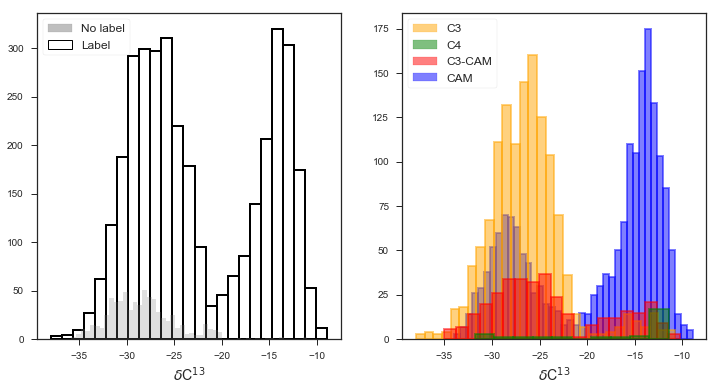

In [9]:
fig, (ax1, ax0) = plt.subplots(1, 2, figsize=(12,6), sharex=True)

ax0.hist(x=filled[filled['Pathway']=='CAM']['dC13'].dropna(), edgecolor='blue',
         linewidth=2, color='blue', alpha=0.5, bins=40)
ax0.hist(x=filled[filled['Pathway']=='C3']['dC13'].dropna(), edgecolor='orange', 
         linewidth=2, color='orange', alpha=0.5, bins=30)
ax0.hist(x=filled[filled['Pathway']=='C3-CAM']['dC13'].dropna(), edgecolor='red', 
         linewidth=2, color='red', alpha=0.5, bins=20)
ax0.hist(x=filled[filled['Pathway']=='C4']['dC13'].dropna(), edgecolor='green', 
         linewidth=2, color='green', alpha=0.5, bins=10)

ax1.hist(x=filled[filled['Pathway'].isin(['C3', 'C4', 'CAM', 'C3-CAM', 'C3-C4'])]['dC13'].dropna(), 
         fc=(1, 1, 1, 1), edgecolor='black', linewidth=2, alpha=1, bins=25)
ax1.hist(x=filled[filled['Pathway'].isnull()]['dC13'].dropna(), color='grey', alpha=0.25, bins=50)

orange_patch = mpatches.Patch(color='orange', alpha=0.5, label='C3', )
green_patch = mpatches.Patch(color='green', alpha=0.5, label='C4')
red_patch = mpatches.Patch(color='red', alpha=0.5, label='C3-CAM')
blue_patch = mpatches.Patch(color='blue', alpha=0.5, label='CAM')

ax0.legend(handles=[orange_patch, green_patch, red_patch, blue_patch], fontsize=12, frameon=True, )
ax0.set_xlabel('$\delta$C$^{13}$', size=14)

grey_patch = mpatches.Patch(color='grey', alpha=0.5, label='No label')
black_patch = mpatches.Patch(facecolor='white', edgecolor='black', linewidth=1, label='Label')

ax1.legend(handles=[grey_patch, black_patch], fontsize=12, frameon=True, )
ax1.set_xlabel('$\delta$C$^{13}$', size=14);

Our known pathways now dwarf our unknown, but the data don't seem to make much sense now as we have a lot of "CAM" taxa less negative than -22, and vice versa with C3 taxa. This is because of the bias in records in the original database. Because the original database is biased towards CAM taxa, there are many genera who's only observation comes from a one, or a few, CAM taxa. This means that all other observations within that genus will be labeled as "CAM" simply because it is the only measurements we have. Let's inspect some of these weird observations. 

In [10]:
drop_odd = filled.loc[~((filled['Pathway']=='CAM') & (filled['dC13']<-22))]

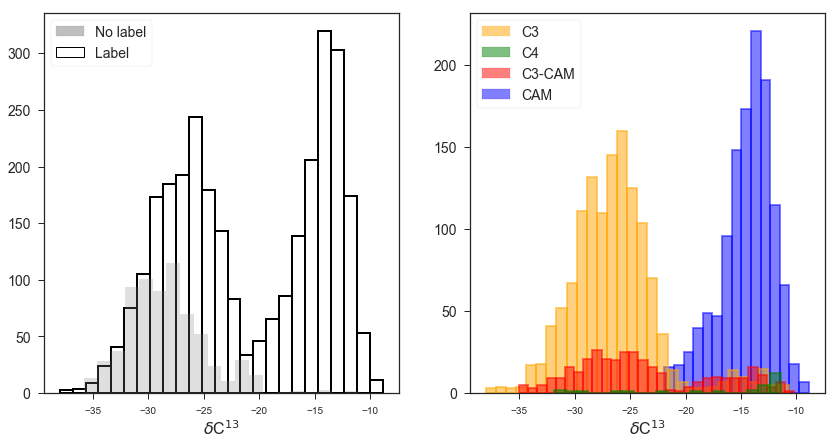

In [11]:
fig, (ax1, ax0) = plt.subplots(1, 2, figsize=(14,7), sharex=True)

ax0.hist(x=drop_odd[drop_odd['Pathway']=='CAM']['dC13'].dropna(), edgecolor='blue',
         linewidth=2, color='blue', alpha=0.5, bins=15)
ax0.hist(x=drop_odd[drop_odd['Pathway']=='C3']['dC13'].dropna(), edgecolor='orange', 
         linewidth=2, color='orange', alpha=0.5, bins=30)
ax0.hist(x=drop_odd[drop_odd['Pathway']=='C3-CAM']['dC13'].dropna(), edgecolor='red', 
         linewidth=2, color='red', alpha=0.5, bins=30)
ax0.hist(x=drop_odd[drop_odd['Pathway']=='C4']['dC13'].dropna(), edgecolor='green', 
         linewidth=2, color='green', alpha=0.5, bins=20)

ax1.hist(x=drop_odd[drop_odd['Pathway'].isin(['C3', 'C4', 'CAM', 'C3-CAM', 'C3-C4'])]['dC13'].dropna(), 
         fc=(1, 1, 1, 1), edgecolor='black', linewidth=2, alpha=1, bins=25)
ax1.hist(x=drop_odd[drop_odd['Pathway'].isnull()]['dC13'].dropna(), color='grey', alpha=0.25, bins=20)

orange_patch = mpatches.Patch(color='orange', alpha=0.5, label='C3', )
green_patch = mpatches.Patch(color='green', alpha=0.5, label='C4')
red_patch = mpatches.Patch(color='red', alpha=0.5, label='C3-CAM')
blue_patch = mpatches.Patch(color='blue', alpha=0.5, label='CAM')

ax0.legend(handles=[orange_patch, green_patch, red_patch, blue_patch], fontsize=14, frameon=True, loc='upper left')
ax0.set_xlabel('$\delta$C$^{13}$', size=16)
ax0.tick_params(axis='y', which='major', labelsize=14)

grey_patch = mpatches.Patch(color='grey', alpha=0.5, label='No label')
black_patch = mpatches.Patch(facecolor='white', edgecolor='black', linewidth=1, label='Label')

ax1.legend(handles=[grey_patch, black_patch], fontsize=14, frameon=True, loc='upper left')
ax1.set_xlabel('$\delta$C$^{13}$', size=16)
ax1.tick_params(axis='y', which='major', labelsize=14);

# plt.savefig('/GitHub/photo_db/images/dC13_hist_imputed.pdf', format='pdf', transparent=True, dpi=300);

`photo_db` can also impute quantitative measurements using an average by species and genus.

In [15]:
fill_avg = photo_db.fill_numeric(df=drop_odd, group_by='Species', to_fill=['leaf_thickness_um', "FM_DM"])
photo_db.db_info(fill_avg)
fill_avg = photo_db.fill_numeric(df=fill_avg, group_by='Genus', to_fill=['leaf_thickness_um', "FM_DM"])

The CAM database consists of:
	4811 observations,                                            
	55 families,                                            
	12 subfamiles,                                            
	13 tribes,                                            
	21 subtribes,                                            
	421 genera, and                                            
	3037 species from 61 publications.                                            
0.81 of the data matrix is missing and                                            
3666 observations have known photosynthetic pathways.


The CAM database consists of:
	4811 observations,                                            
	55 families,                                            
	12 subfamiles,                                            
	13 tribes,                                            
	21 subtribes,                                            
	421 genera, and                                            
	3037 species from 61 publications.                                            
0.794 of the data matrix is missing and                                            
3666 observations have known photosynthetic pathways.


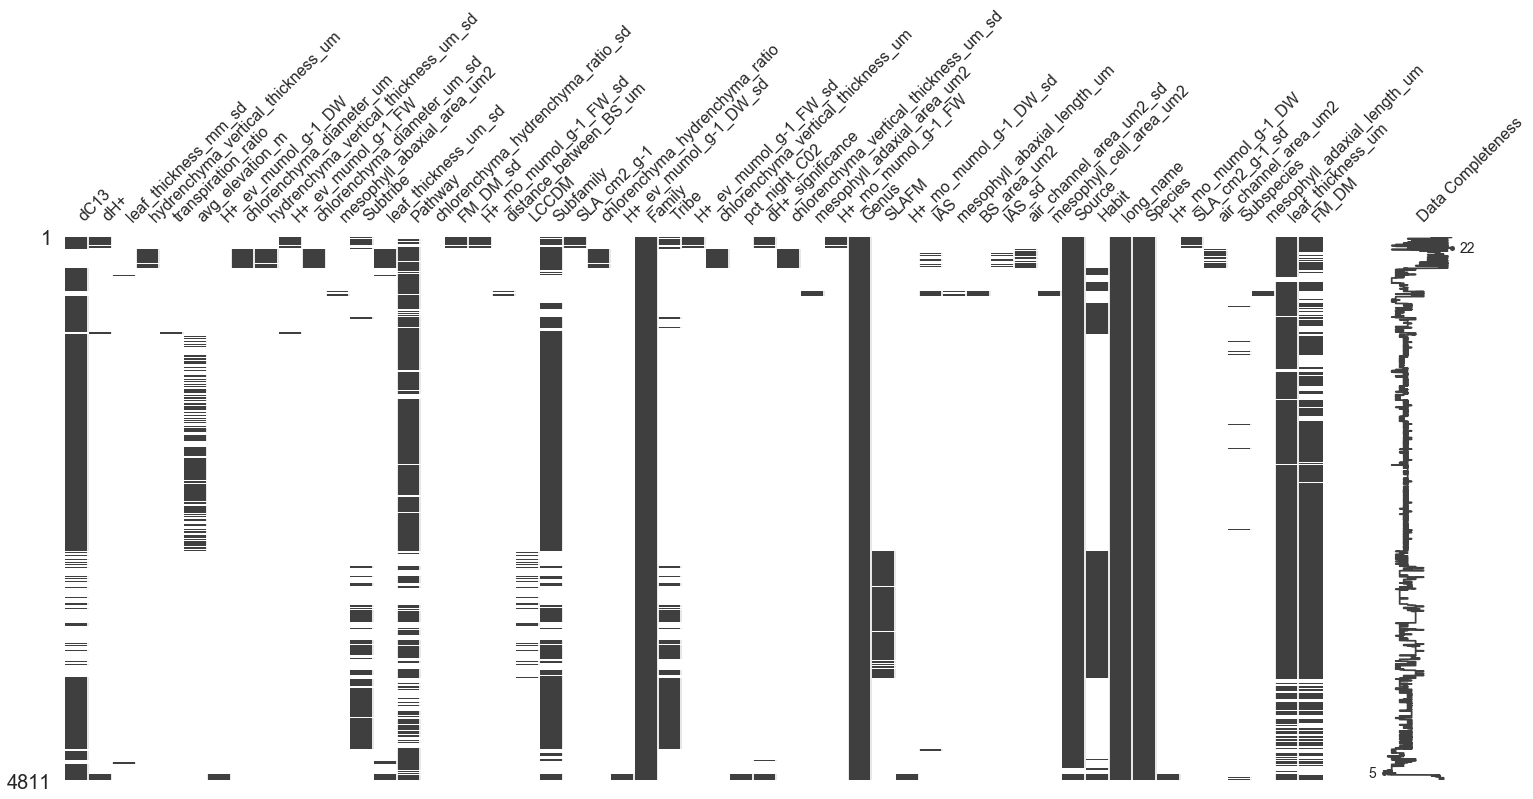

In [16]:
photo_db.db_info(fill_avg, plt_missingdata=True, labels=True)

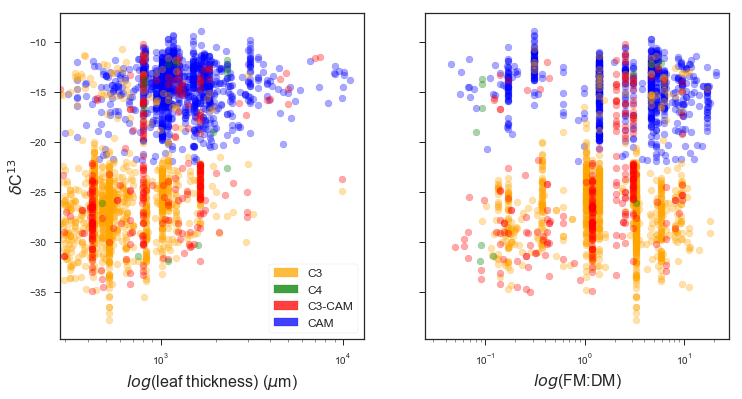

In [17]:
fig, (ax, ax1) = plt.subplots(1,2, figsize=(12,6), sharey=True)

ax.scatter(x=fill_avg.loc[fill_avg['Pathway']=='CAM']['leaf_thickness_um'], 
           y=fill_avg.loc[fill_avg['Pathway']=='CAM']['dC13'], marker='o', alpha=0.34, c='blue')
ax.scatter(x=fill_avg.loc[fill_avg['Pathway']=='C3']['leaf_thickness_um'], 
           y=fill_avg.loc[fill_avg['Pathway']=='C3']['dC13'], marker='o', alpha=0.34, c='orange')
ax.scatter(x=fill_avg.loc[fill_avg['Pathway']=='C3-CAM']['leaf_thickness_um'], 
           y=fill_avg.loc[fill_avg['Pathway']=='C3-CAM']['dC13'], marker='o', alpha=0.34, c='red')
ax.scatter(x=fill_avg.loc[fill_avg['Pathway']=='C4']['leaf_thickness_um'], 
           y=fill_avg.loc[fill_avg['Pathway']=='C4']['dC13'], marker='o', alpha=0.34, c='green')

ax1.scatter(x=fill_avg.loc[fill_avg['Pathway']=='CAM']['FM_DM'], 
           y=fill_avg.loc[fill_avg['Pathway']=='CAM']['dC13'], marker='o', alpha=0.34, c='blue')
ax1.scatter(x=fill_avg.loc[fill_avg['Pathway']=='C3']['FM_DM'], 
           y=fill_avg.loc[fill_avg['Pathway']=='C3']['dC13'], marker='o', alpha=0.34, c='orange')
ax1.scatter(x=fill_avg.loc[fill_avg['Pathway']=='C3-CAM']['FM_DM'], 
           y=fill_avg.loc[fill_avg['Pathway']=='C3-CAM']['dC13'], marker='o', alpha=0.34, c='red')
ax1.scatter(x=fill_avg.loc[fill_avg['Pathway']=='C4']['FM_DM'], 
           y=fill_avg.loc[fill_avg['Pathway']=='C4']['dC13'], marker='o', alpha=0.34, c='green')

ax.set_xscale('log')
ax1.set_xscale('log')
ax.set_xlabel('$log$(leaf thickness) ($\mu$m)', size=16)
ax.set_ylabel('$\delta$C$^{13}$', size=16)
ax1.set_xlabel('$log$(FM:DM)', size=16)

orange_patch = mpatches.Patch(color='orange', alpha=0.75, label='C3', )
green_patch = mpatches.Patch(color='green', alpha=0.75, label='C4')
red_patch = mpatches.Patch(color='red', alpha=0.75, label='C3-CAM')
blue_patch = mpatches.Patch(color='blue', alpha=0.75, label='CAM')

ax.legend(handles=[orange_patch, green_patch, red_patch, blue_patch], fontsize=12, frameon=True);

## "The List", expanded
"The List" refers to the ever-growing list of genera that contain CAM lineages&mdash;compiled by Dr. Andrew Smith, Dr. Joe Holtum, and Dr. Klaus Winter. I have expanded it with _every_ instance of a noted photosynthetic pathway that I can find. Most of the C4 designations came from Dr. Rowan Sage's recent acticle with a [list of C4 lineages](https://academic.oup.com/jxb/article/67/14/4039/2197596) (Sage 2016).

In [18]:
thelist = photo_db.pull_data('the_list')
thelist.head()

,Family,Genus,C3,CAM,C3-CAM,C4-CAM,C4,C3-C4,Sources,Order,Subfamily,Tribe,Subtribe
0,Orchidaceae,Aa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Asteraceae,Aaronsohnia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fabaceae,Abacosa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fabaceae,Abarema,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Asteraceae,Abasoloa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
thelist = thelist.drop(['Subfamily', 'Tribe', 'Subtribe', 'Sources', 'Order'], axis=1)

In [20]:
print len(thelist)
thelist.describe()

20917


,C3,CAM,C3-CAM,C4-CAM,C4,C3-C4
count,1475.000000,1475.000000,1475.000000,1475.000000,1475.000000,888.000000
mean,0.443390,0.304407,0.014915,0.000678,0.274576,0.013514
std,0.496953,0.460312,0.121255,0.026038,0.446452,0.115525
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The list is a bunch of binary indicators for each type of photosynthesis. We can see that we have roughly 21,000 genera, but only about 1,500 of these have identified pathways. Now let's see how these labels are distributed amongst families.

In [21]:
thelist.set_index("Family", inplace=True)

In [22]:
fam_pct_id = {}
for family, row in thelist.iterrows():
    if type(thelist.loc[family].count())!=np.int64:
        fam_pct_id[family] = sorted(thelist.loc[family].count())[1]/float(thelist.loc[family].count()['Genus'])
    else:
        fam_pct_id[family] = 0.0

In [23]:
fam_pct = pd.DataFrame(columns=['Family', 'pct'])
fam_pct['Family'] = sorted(fam_pct_id.keys())
fam_pct['pct'] = [fam_pct_id[fam] for fam in sorted(fam_pct_id.keys())]
fam_pct['size'] = [len(thelist.loc[fam]) for fam in fam_pct['Family']]
fam_pct.head()

,Family,pct,size
0,Acanthaceae,0.007092,423
1,Achariaceae,0.000000,37
2,Achatocarpaceae,0.000000,2
3,Acoraceae,0.000000,7
4,Actinidiaceae,0.000000,4


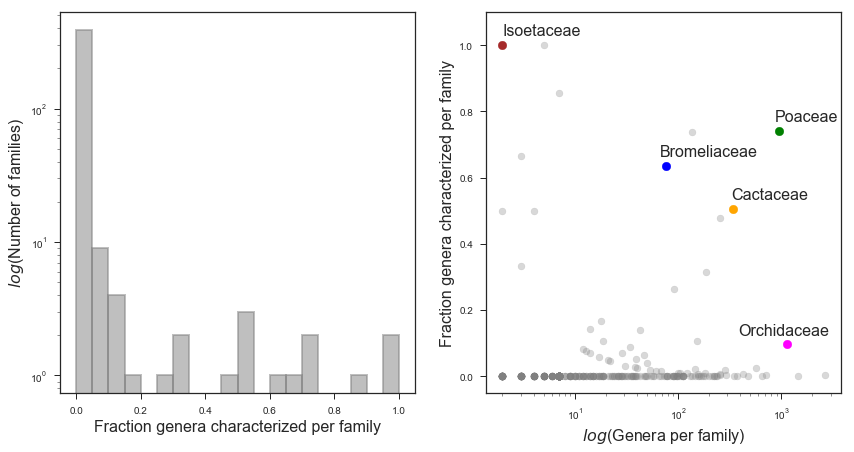

In [24]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14,7))

ax0.hist(x=fam_pct['pct'], edgecolor='grey',linewidth=2, color='grey', alpha=0.5, bins=20)

ax1.scatter(x=fam_pct['size'], y=fam_pct['pct'], color="grey", alpha=0.3)
ax1.scatter(x=fam_pct.loc[fam_pct["Family"]=="Orchidaceae", "size"], 
            y=fam_pct.loc[fam_pct["Family"]=="Orchidaceae","pct"],
            color="magenta", s=75)
ax1.scatter(x=fam_pct.loc[fam_pct["Family"]=="Bromeliaceae", "size"], 
            y=fam_pct.loc[fam_pct["Family"]=="Bromeliaceae","pct"],
            color="blue", s=75)
ax1.scatter(x=fam_pct.loc[fam_pct["Family"]=="Poaceae", "size"], 
            y=fam_pct.loc[fam_pct["Family"]=="Poaceae","pct"],
            color="green", s=75)
ax1.scatter(x=fam_pct.loc[fam_pct["Family"]=="Cactaceae", "size"], 
            y=fam_pct.loc[fam_pct["Family"]=="Cactaceae","pct"],
            color="orange", s=75)
ax1.scatter(x=fam_pct.loc[fam_pct["Family"]=="Isoetaceae", "size"], 
            y=fam_pct.loc[fam_pct["Family"]=="Isoetaceae","pct"],
            color="brown", s=75)

ax1.text(x=fam_pct.loc[fam_pct["Family"]=="Bromeliaceae", "size"]-10, 
            y=fam_pct.loc[fam_pct["Family"]=="Bromeliaceae","pct"]+0.03, 
            s="Bromeliaceae", size=16)
ax1.text(x=fam_pct.loc[fam_pct["Family"]=="Orchidaceae", "size"]-750, 
            y=fam_pct.loc[fam_pct["Family"]=="Orchidaceae","pct"]+0.03, 
            s="Orchidaceae", size=16)
ax1.text(x=fam_pct.loc[fam_pct["Family"]=="Poaceae", "size"]-100, 
            y=fam_pct.loc[fam_pct["Family"]=="Poaceae","pct"]+0.03, 
            s="Poaceae", size=16)
ax1.text(x=fam_pct.loc[fam_pct["Family"]=="Cactaceae", "size"]-10, 
            y=fam_pct.loc[fam_pct["Family"]=="Cactaceae","pct"]+0.03, 
            s="Cactaceae", size=16)
ax1.text(x=fam_pct.loc[fam_pct["Family"]=="Isoetaceae", "size"], 
            y=fam_pct.loc[fam_pct["Family"]=="Isoetaceae","pct"]+0.03, 
            s="Isoetaceae", size=16)

ax0.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylim([-0.05, 1.1])

ax0.set_xlabel("Fraction genera characterized per family", size=16)
ax0.set_ylabel("$log$(Number of families)", size=16)
ax1.set_xlabel("$log$(Genera per family)", size=16)
ax1.set_ylabel("Fraction genera characterized per family", size=16);
# plt.savefig('/GitHub/photo_db/images/thelist_pct_char.pdf', format='pdf', transparent=True, dpi=300);

So, it looks like the vast majority of families have no genera with photosynthesis type labels and most of the families that are highly labeled have very few genera. On the other end of the spectrum are very, very large groups like the orchids, which do have many labels but they make up only a small fraction of the entire family. In the upper right quadrant of the right figure we see a few familiar families that have been the subject of many photosynthesis studies over the years. 

Now that we've explored the data and `photo_db` a little we'll use these resources to try to classify photosynthesis types with machine learning. We'll first start with a bromeliad dataset (Males 2018).


# Males (2018): Bromeliads
The bromeliad data contains measurements of
* Air channel area ($\mu$m$^2$), 
* Chlorenchyma diameter ($\mu$m), 
* Chlorenchyma to hydrenchyma ratio, 
* Chlorenchyma vertical thickness ($\mu$m), 
* Hydrenchyma vertical thickness ($\mu$m)', and 
* Leaf thickness ($\mu$m).

The data also contain some measurements of intercellular airspace, but I'll drop these (see below).

In [29]:
broms_2018 = cam_db[cam_db['Source']=='Males (2018)']
broms_2018.reset_index(drop=True, inplace=True)
# Retain only those features with measurements
broms_2018 = broms_2018[['long_name', 'air_channel_area_um2', 'chlorenchyma_diameter_um', 
                       'chlorenchyma_hydrenchyma_ratio', 'chlorenchyma_vertical_thickness_um', 
                       'hydrenchyma_vertical_thickness_um', 'leaf_thickness_um', 
                    'Family', 'Subfamily', 'Genus', 'Pathway', 'IAS', 'Source']]
broms_2018.head()

,long_name,air_channel_area_um2,chlorenchyma_diameter_um,chlorenchyma_hydrenchyma_ratio,chlorenchyma_vertical_thickness_um,hydrenchyma_vertical_thickness_um,leaf_thickness_um,Family,Subfamily,Genus,Pathway,IAS,Source
0,Acanthostachys strobilacea,14082.0,28.77,0.37,830.72,2248.75,3079.47,Bromeliaceae,Bromelioideae,Acanthostachys,CAM,NaN,Males (2018)
1,Aechmea alba,13110.0,34.69,11.38,747.03,65.62,812.65,Bromeliaceae,Bromelioideae,Aechmea,CAM,NaN,Males (2018)
2,Aechmea bromeliifolia var albobracteata,92331.0,47.89,2.96,1772.49,597.95,2370.44,Bromeliaceae,Bromelioideae,Aechmea,CAM,NaN,Males (2018)
3,Aechmea bromeliifolia var bromeliifolia,68975.0,50.20,8.86,1291.67,145.75,1437.42,Bromeliaceae,Bromelioideae,Aechmea,CAM,NaN,Males (2018)
4,Aechmea capixabae,7243.0,37.79,0.69,353.61,514.35,867.96,Bromeliaceae,Bromelioideae,Aechmea,CAM,NaN,Males (2018)


The CAM database consists of:
	163 observations,                                            
	1 families,                                            
	3 subfamiles,                                            
	None tribes,                                            
	None subtribes,                                            
	28 genera, and                                            
	163 species from 1 publications.                                            
0.0812 of the data matrix is missing and                                            
162 observations have known photosynthetic pathways.


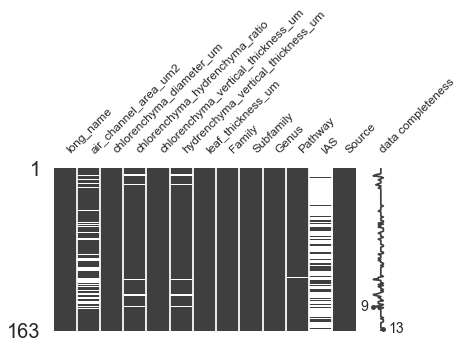

In [30]:
photo_db.db_info(cam_db=broms_2018, plt_missingdata=True, figsize=(6,3), labels=True, fontsize=12)

In [31]:
# Show some basic statistics
broms_2018.describe()

,air_channel_area_um2,chlorenchyma_diameter_um,chlorenchyma_hydrenchyma_ratio,chlorenchyma_vertical_thickness_um,hydrenchyma_vertical_thickness_um,leaf_thickness_um,IAS
count,127.000000,163.000000,156.000000,163.000000,156.000000,163.000000,42.000000
mean,31669.456693,31.923926,1.935000,556.992147,487.255321,1023.322270,9.145000
std,41415.959926,21.640931,3.197948,476.897201,433.609592,710.544097,4.401081
min,404.000000,9.250000,0.130000,70.650000,31.780000,170.730000,4.160000
25%,10490.000000,15.045000,0.557500,202.500000,216.595000,497.725000,5.857500
50%,15257.000000,25.090000,0.900000,390.070000,336.500000,770.460000,7.095000
75%,40266.000000,42.050000,1.542500,735.980000,582.242500,1437.820000,12.412500
max,351516.000000,124.160000,24.000000,2518.360000,2962.680000,4085.720000,19.420000


In [32]:
print("There are {} IAS measurements. This is {:2.1f}% of all species".format(
    len(broms_2018['IAS'].unique()), 100*float(len(broms_2018['IAS'].unique()))/len(broms_2018)))

There are 42 IAS measurements. This is 25.8% of all species


For this reason, I'll drop this feature from the dataset, along with other taxa with missing data.

In [33]:
broms_2018.drop(labels=['IAS'], axis=1, inplace=True)
broms_2018.dropna(inplace=True)
broms_2018.reset_index(drop=True, inplace=True)

In [34]:
photo_db.db_info(cam_db=broms_2018)

The CAM database consists of:
	123 observations,                                            
	1 families,                                            
	3 subfamiles,                                            
	None tribes,                                            
	None subtribes,                                            
	23 genera, and                                            
	123 species from 1 publications.                                            
0.0 of the data matrix is missing and                                            
123 observations have known photosynthetic pathways.


In [35]:
brom_features = ['air_channel_area_um2', 'chlorenchyma_diameter_um',
                'chlorenchyma_hydrenchyma_ratio', 'chlorenchyma_vertical_thickness_um',
                'hydrenchyma_vertical_thickness_um', 'leaf_thickness_um']

### Visualization of raw and log-transformed data
Now that we've gotten a complete matrix, let's see what the data look like. I'll run analyses of the raw data as well as log-transformed data, as in Males (2018).

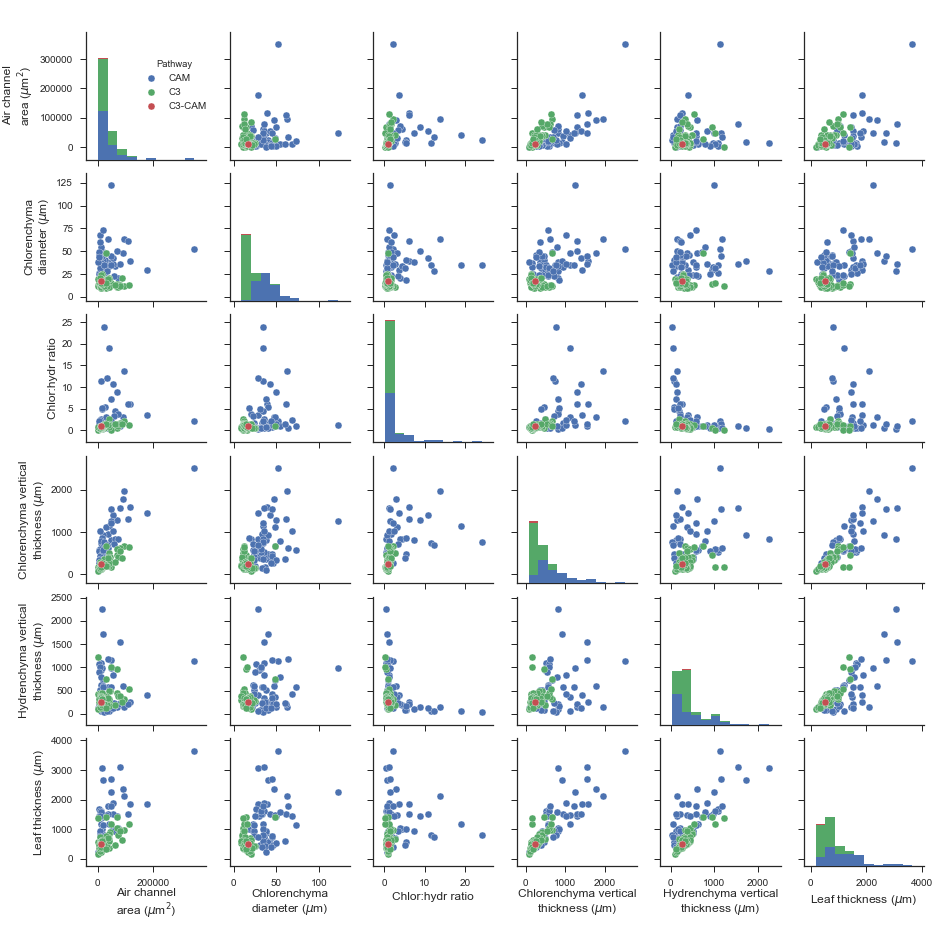

In [36]:
g = sns.pairplot(broms_2018, hue="Pathway", markers='o', size=1)
g.fig.set_size_inches(12, 12)
replacements = dict(zip(brom_features,['Air channel\narea ($\mu$m$^2$)',
                                       'Chlorenchyma\ndiameter ($\mu$m)',
                                       'Chlor:hydr ratio',
                                       'Chlorenchyma vertical\nthickness ($\mu$m)',
                                       'Hydrenchyma vertical\nthickness ($\mu$m)',
                                       'Leaf thickness ($\mu$m)']))
for i in range(len(brom_features)):
    for j in range(len(brom_features)):
        xlabel = g.axes[i][j].get_xlabel()
        ylabel = g.axes[i][j].get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel], size=12)
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel], size=12)

g.fig.get_children()[-1].set_bbox_to_anchor((0.25, 0.975, 0, 0))
plt.tight_layout();

Create log-transformed dataframe

In [37]:
logbroms_2018 = np.log(broms_2018[brom_features]).join(broms_2018[list(set(broms_2018.columns)-set(brom_features))])

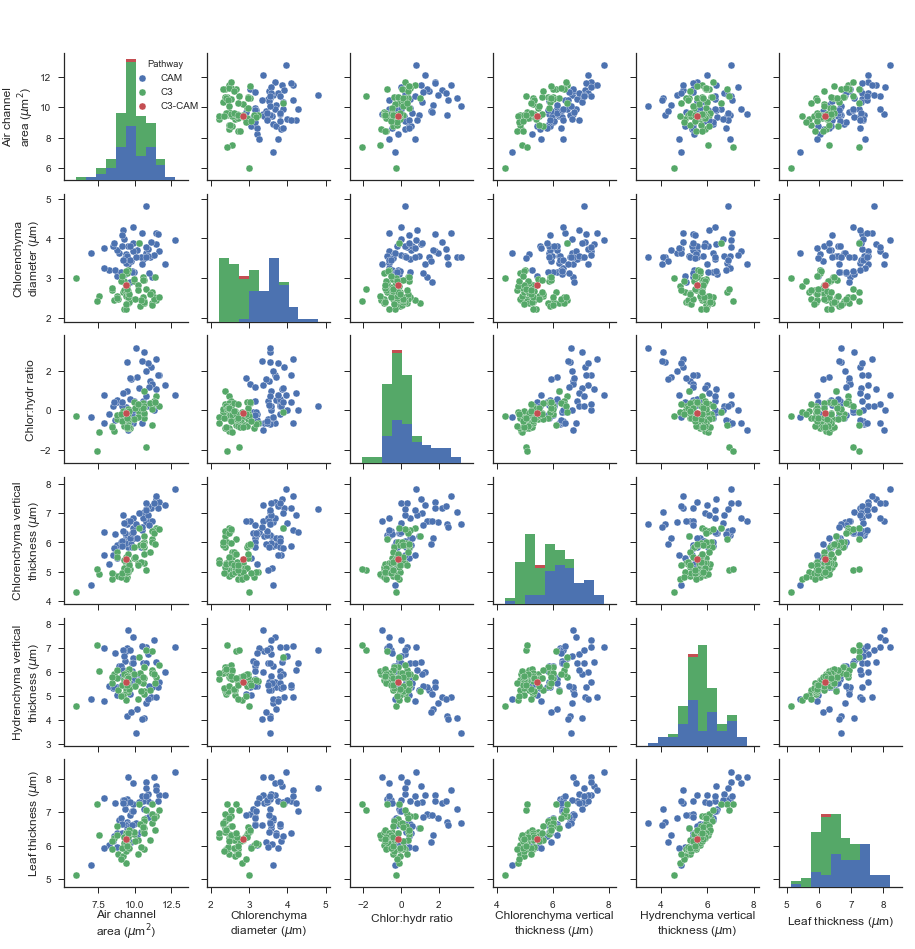

In [38]:
g = sns.pairplot(logbroms_2018, hue="Pathway", markers='o', size=1,)
g.fig.set_size_inches(12, 12)
replacements = dict(zip(brom_features,['Air channel\narea ($\mu$m$^2$)',
                                       'Chlorenchyma\ndiameter ($\mu$m)',
                                       'Chlor:hydr ratio',
                                       'Chlorenchyma vertical\nthickness ($\mu$m)',
                                       'Hydrenchyma vertical\nthickness ($\mu$m)',
                                       'Leaf thickness ($\mu$m)']))
for i in range(len(brom_features)):
    for j in range(len(brom_features)):
        xlabel = g.axes[i][j].get_xlabel()
        ylabel = g.axes[i][j].get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel], size=12)
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel], size=12)

g.fig.get_children()[-1].set_bbox_to_anchor((0.24, 0.9999, 0, 0))
plt.tight_layout();

Plot scatter matrix for log-tranformed data.

Take a look at the correlation between measurements. Heatmaps are okay for qualitative assessments but I don't like them for quantitative judgements.

In [39]:
# Compute the correlation matrix
brom_2018_corr = broms_2018[brom_features].corr()

# Generate a mask for the upper triangle
brom_2018_mask = np.zeros_like(brom_2018_corr, dtype=np.bool)
brom_2018_mask[np.triu_indices_from(brom_2018_mask)] = True

# Repeat for log-transformed
logbrom_2018_corr = logbroms_2018[brom_features].corr()
logbrom_2018_mask = np.zeros_like(logbrom_2018_corr, dtype=np.bool)
logbrom_2018_mask[np.triu_indices_from(logbrom_2018_mask)] = True

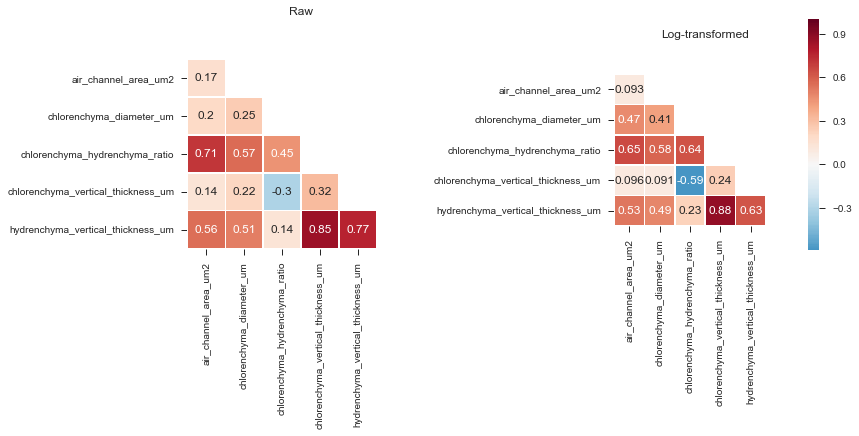

In [46]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12, 6))

sns.heatmap(brom_2018_corr, annot=True, mask=brom_2018_mask, cmap="RdBu_r", center=0,
            square=True, linewidths=.5, cbar=False, ax=ax0)
sns.heatmap(logbrom_2018_corr, annot=True, mask=logbrom_2018_mask, cmap="RdBu_r", center=0,
            square=True, linewidths=.5, cbar=True, ax=ax1)

ax0.set_title('Raw')
ax0.set_xticks([0.5, 1.5, 2.5, 3.5, 4.5])
ax0.set_yticks([1.5, 2.5, 3.5, 4.5, 5.5])
ax1.set_title('Log-transformed')
ax1.set_xticks([0.5, 1.5, 2.5, 3.5, 4.5])
ax1.set_yticks([1.5, 2.5, 3.5, 4.5, 5.5])

plt.tight_layout();

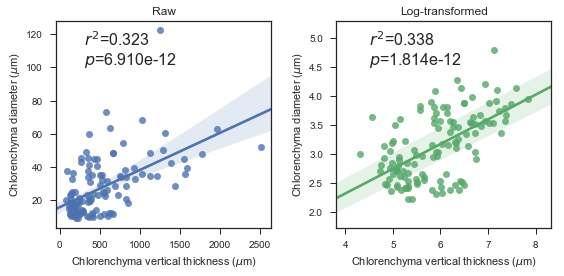

In [45]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(8, 4))

# Get regression stats
regstats = sp.stats.linregress(x=broms_2018['chlorenchyma_vertical_thickness_um'],
                               y=broms_2018['chlorenchyma_diameter_um'])
logregstats= sp.stats.linregress(x=logbroms_2018['chlorenchyma_vertical_thickness_um'], 
                                 y=logbroms_2018['chlorenchyma_diameter_um'])
sns.regplot('chlorenchyma_vertical_thickness_um', 'chlorenchyma_diameter_um', data=broms_2018, ax=ax0)
sns.regplot('chlorenchyma_vertical_thickness_um', 'chlorenchyma_diameter_um', data=logbroms_2018, ax=ax1)

ax1.set_xlim([min(logbroms_2018['chlorenchyma_vertical_thickness_um']-0.5),
              max(logbroms_2018['chlorenchyma_vertical_thickness_um']+0.5)])
ax1.set_ylim([min(logbroms_2018['chlorenchyma_diameter_um']-0.5),
              max(logbroms_2018['chlorenchyma_diameter_um']+0.5)])

ax0.text(300, 100, "$r^2$="+str(round(regstats[2]**2,3))+"\n$p$="+str('{:0.3e}'.format(
    regstats[3])), size=16)
ax1.text(4.5, 4.5, "$r^2$="+str(round(logregstats[2]**2,3))+"\n$p$="+str('{:0.3e}'.format(
    logregstats[3])), size=16)

ax0.set_xlabel("Chlorenchyma vertical thickness ($\mu$m)")
ax0.set_ylabel("Chlorenchyma diameter ($\mu$m)")
ax1.set_xlabel("Chlorenchyma vertical thickness ($\mu$m)")
ax1.set_ylabel("Chlorenchyma diameter ($\mu$m)")

ax0.set_title("Raw")
ax1.set_title("Log-transformed")

plt.tight_layout();

The plot above is a replicate of Males Fig. 4a. He reports an $r^2=0.37$ for the log-transformed data, while ours is $0.338$, so we aren't far off after removing some of the data. We should expect these measurements to be correlated as they are both distance measurements from the same cells.

Next, we'll replicate the PCA.
### PCA

In [42]:
brom_pca_config = PCA(n_components=2)
brom_temp = broms_2018[brom_features]
brom_PCA = brom_pca_config.fit(brom_temp).transform(brom_temp)

logbrom_pca_config = PCA(n_components=2)
logbrom_temp = logbroms_2018[brom_features]
logbrom_PCA = logbrom_pca_config.fit(logbrom_temp).transform(logbrom_temp)

print('Explained variance ratio (first two components): {}'.format(brom_pca_config.explained_variance_ratio_))
print('Log-transformed explained variance ratio (first two components): {}'.format(
    logbrom_pca_config.explained_variance_ratio_))

Explained variance ratio (first two components): [  9.99704620e-01   2.52636712e-04]
Log-transformed explained variance ratio (first two components): [ 0.54351906  0.27629338]


The raw data explains over 99% of the total variance while the log-transformed data explains about 82% (consistent with Male's analysis).

In [43]:
# Plotting shortcuts
color_map = {'C3':'green', 'CAM':'blue', 'C3-CAM':'red'}
shape_map = {'Bromelioideae':'o', 'Tillandsioideae':'^', 'Pitcairnioideae':'*'}

In [44]:
brom_PCA_DF = pd.DataFrame(brom_PCA, columns=['X', 'Y'])
brom_PCA_DF['Pathway'] = broms_2018['Pathway']
brom_PCA_DF['Subfamily'] = broms_2018['Subfamily']
brom_PCA_DF['color'] = [color_map[pathway] for pathway in brom_PCA_DF['Pathway']]
brom_PCA_DF['shape'] = [shape_map[subfam] for subfam in brom_PCA_DF['Subfamily']]

logbrom_PCA_DF = pd.DataFrame(logbrom_PCA, columns=['X', 'Y'])
logbrom_PCA_DF['Pathway'] = logbroms_2018['Pathway']
logbrom_PCA_DF['Subfamily'] = logbroms_2018['Subfamily']
logbrom_PCA_DF['color'] = [color_map[pathway] for pathway in logbrom_PCA_DF['Pathway']]
logbrom_PCA_DF['shape'] = [shape_map[subfam] for subfam in logbrom_PCA_DF['Subfamily']]

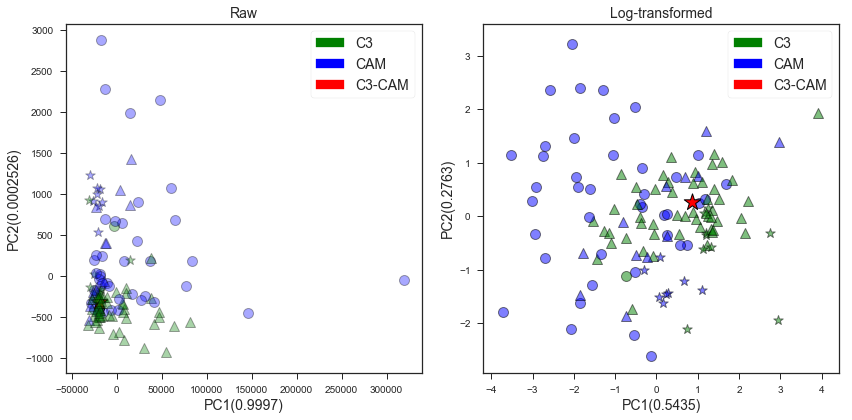

In [48]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))

for i in range(len(brom_PCA_DF)):
    if brom_PCA_DF['Pathway'][i]=='CAM':
        ax0.scatter(brom_PCA_DF.iloc[i, 0], brom_PCA_DF.iloc[i,1], alpha = 0.34,
                    c=brom_PCA_DF['color'][i], marker=brom_PCA_DF['shape'][i], 
                    edgecolors='black', linewidths=1, s=100)
    elif brom_PCA_DF['Pathway'][i]=='C3-CAM':
        ax0.scatter(brom_PCA_DF.iloc[i, 0], brom_PCA_DF.iloc[i,1],
                    c=brom_PCA_DF['color'][i], marker='*', 
                    edgecolors='black', linewidths=1, s=300)
    else:
        ax0.scatter(brom_PCA_DF.iloc[i, 0], brom_PCA_DF.iloc[i,1], alpha = 0.34,
                    c=brom_PCA_DF['color'][i], marker=brom_PCA_DF['shape'][i], 
                    edgecolors='black', linewidths=1, s=100)
        
for i in range(len(logbrom_PCA_DF)):
    if logbrom_PCA_DF['Pathway'][i]=='CAM':
        ax1.scatter(logbrom_PCA_DF.iloc[i, 0], logbrom_PCA_DF.iloc[i,1], alpha = 0.5,
                    c=logbrom_PCA_DF['color'][i], marker=logbrom_PCA_DF['shape'][i], 
                    edgecolors='black', linewidths=1, s=100)
    elif logbrom_PCA_DF['Pathway'][i]=='C3-CAM':
        ax1.scatter(logbrom_PCA_DF.iloc[i, 0], logbrom_PCA_DF.iloc[i,1],
                    c=logbrom_PCA_DF['color'][i], marker='*', 
                    edgecolors='black', linewidths=1, s=300)
    else:
        ax1.scatter(logbrom_PCA_DF.iloc[i, 0], logbrom_PCA_DF.iloc[i,1], alpha = 0.5,
                    c=logbrom_PCA_DF['color'][i], marker=logbrom_PCA_DF['shape'][i], 
                    edgecolors='black', linewidths=1, s=100)
        
ax0.set_xlabel("PC1("+str('{:.4}'.format(brom_pca_config.explained_variance_ratio_[0]))+")", size=14)
ax0.set_ylabel("PC2("+str('{:.4}'.format(brom_pca_config.explained_variance_ratio_[1]))+")", size=14)
ax1.set_xlabel("PC1("+str('{:.4}'.format(logbrom_pca_config.explained_variance_ratio_[0]))+")", size=14)
ax1.set_ylabel("PC2("+str('{:.4}'.format(logbrom_pca_config.explained_variance_ratio_[1]))+")", size=14)
    
red_patch = mpatches.Patch(color='red', label='C3-CAM')
green_patch = mpatches.Patch(color='green', label='C3')
blue_patch = mpatches.Patch(color='blue', label='CAM')

ax0.legend(handles=[green_patch, blue_patch, red_patch], fontsize=14, frameon=True,)
ax1.legend(handles=[green_patch, blue_patch, red_patch], fontsize=14, frameon=True,)

ax0.set_title('Raw', size=14)
ax1.set_title('Log-transformed', size=14)
plt.tight_layout();

Above, triangles are CAM, circles are C3, and the stars are C3-CAM intermediates (the star is hard to pick out because its in the center of the densest area of the plot). Qualitatively, the log-transformed PCA is close to Male's PCA, although his addition of convex hulls makes it harder to see. 

Now to use support vector machines (SVM) and random forests (RF) to classify C3, CAM, and C3-CAM. Basically, SVMs apply transformations to our data (observations) and look for breaks between the classes in multidimensional space. Support vectors are built to maximize the buffer space around those breaks for each observation. We'll use a linear model for transformations, but nonlinear models can be applied. 

Random forests also look for breaks between classes, but in a different way. RFs use a set of decision trees that step through our features one by one, often revisiting the same feature more than once, each time creating a break that separates the most observations into their respective classifications until all observations have been sorted.

Before we use our real data, I'll show two cases where these techniques outperform traditional methods like PCA. 

## Support vector machines (SVMs)
### An example
Here is a quick example to demonstrate the utility of support vector machines. Suppose we have red and blue classes as distributed below.

In [49]:
circledata = pd.DataFrame()
circledata['x'] = np.random.uniform(low=-1.0, high=1.0, size=1000)
circledata['y'] = np.random.uniform(low=-1.0, high=1.0, size=1000)
circleclasses = []
for i, row in circledata.iterrows():
    if -(row['x']**2+row['y']**2)<-0.25:
        circleclasses.append('red')
    else:
        circleclasses.append('blue')
circledata['color'] = circleclasses

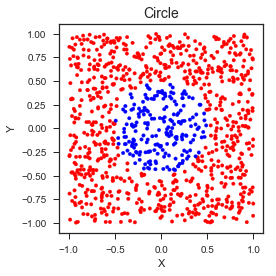

In [67]:
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(circledata['x'], circledata['y'], c=circledata['color'], marker='.')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Circle", size=14)
plt.tight_layout();

We can easily pick out our classes but there are no gaps between them. Maybe PCA can help.

In [68]:
circle_PCA_config = PCA(n_components=2)
circle_temp = circledata[['x','y']]
circle_PCA = circle_PCA_config.fit(circle_temp).transform(circle_temp)
print('Explained variance ratio (first two components): {}'.format(circle_PCA_config.explained_variance_ratio_))

Explained variance ratio (first two components): [ 0.50648109  0.49351891]


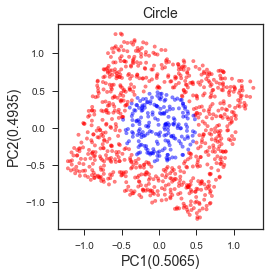

In [69]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(x=circle_PCA[:,0], y=circle_PCA[:,1], c=circledata['color'], alpha=0.5, marker='.')        
ax.set_xlabel("PC1("+str('{:.4}'.format(circle_PCA_config.explained_variance_ratio_[0]))+")", size=14)
ax.set_ylabel("PC2("+str('{:.4}'.format(circle_PCA_config.explained_variance_ratio_[1]))+")", size=14)
ax.set_title('Circle', size=14)
plt.tight_layout();

With PCA we can explain much of the variance, but we still haven't made progress in separating our two classes because our classes aren't correlated with the variance structure. There is an intuitive projective of these data that _would_ allow us the split the classes with a simple plane&mdash;a parabola in 3-space. Let's transform the data with a second degree polynomial and see if we can classify our data.

In [70]:
# Create SVM classification object with 2nd degree polynomial kernel
circle_svm_clf = svm.SVC(kernel='poly',degree=2, random_state=0)

# Split data into training and testing
circle_train_X, circle_test_X, circle_train_y, circle_test_y = train_test_split(
    circledata[['x','y']], circledata['color'], test_size=0.25, random_state=0)

In [71]:
circle_svm_crossval = cross_val_score(circle_svm_clf, circledata[["x","y"]], circledata["color"], cv=5, n_jobs=-1)
circle_svm_preds = cross_val_predict(circle_svm_clf, circledata[["x","y"]], circledata["color"], cv=5, n_jobs=-1)
circle_svm_crosstab = pd.crosstab(circledata["color"], circle_svm_preds, 
                                  rownames=['Actual'], colnames=['Predicted'])

print("Cross-validation accuracy: {:.3} (+/- {:.3})".format(circle_svm_crossval.mean(), circle_svm_crossval.std()))
circle_svm_crosstab

Cross-validation accuracy: 0.996 (+/- 0.00373)


Predicted,blue,red
Actual,,
blue,203,0
red,4,793


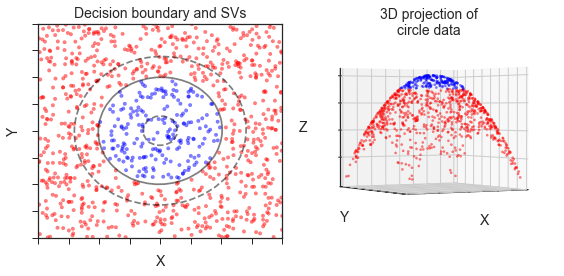

In [72]:
fig = plt.figure(figsize=(8,4))

ax = fig.add_subplot(1,2,1)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
# Fit training data to model
circle_svm_clf.fit(circle_train_X, circle_train_y)
photo_db.plot_svc_decision_function(circle_svm_clf, ax=ax)
ax.scatter(x=circledata['x'], y=circledata['y'], c=circledata['color'], alpha=0.5, marker='.')
ax.set_xlabel("X", size=14)
ax.set_ylabel("Y", size=14)
ax.set_xticklabels([''])
ax.set_yticklabels([''])

plt3d = fig.add_subplot(1,2,2, projection='3d')
circledata['z'] = -(circledata['x']**2+circledata['y']**2)
plt3d.scatter(circledata['x'], circledata['y'], circledata['z'], c=circledata['color'], alpha=0.5, marker='.')

plt3d.set_xlim([-1,1])
plt3d.set_ylim([-1,1])
plt3d.set_xticklabels([''])
plt3d.set_yticklabels([''])
plt3d.set_zticklabels([''])
plt3d.set_xlabel('X', size=14)
plt3d.set_ylabel('Y', size=14)
plt3d.set_zlabel('Z', size=14)
plt3d.view_init(elev=1, azim=60)

ax.set_title('Decision boundary and SVs', size=14)
plt3d.set_title('3D projection of\ncircle data', size=14)

plt.tight_layout();

Now we can see the decision boundary (left) along with a projection with our paraboloid that shows us one way we could imagine separating the circle data by increasing the dimensionality and finding a plane.

## ...back to bromeliads
Unfortunately, because we only have a single C3-CAM species we will not be able to do any classificication with this type of photosynthensis, so we will drop it from our dataset.

In [73]:
broms_2018 = broms_2018[broms_2018['Pathway']!='C3-CAM']
logbroms_2018 = logbroms_2018[logbroms_2018['Pathway']!='C3-CAM']

In [74]:
# Divide into training and testing data (X's) and responses (y's) 
brom_train_X, brom_test_X, brom_train_y, brom_test_y = train_test_split(
    broms_2018[brom_features], broms_2018['Pathway'], test_size=0.25, random_state=0)

# Create and SVM classification object 
brom_svm_clf = svm.SVC(kernel='linear')

Finally, we can fit our model, test its accuracy with cross-validation (number of cross-validations set with the `cv` flag), and print the confusion matrix from another round of cross-validation. _Note that the_ `n_jobs=-1` _option parallelizes the model and cross-validation, which, if you're using a Jupyter Notebook, will require you to interrupt the kernel for every worker that is spawned_.

In [75]:
brom_svm_crossval = cross_val_score(brom_svm_clf, broms_2018[brom_features], broms_2018['Pathway'], 
                                    cv=5, n_jobs=-1)
brom_svm_preds = cross_val_predict(brom_svm_clf, broms_2018[brom_features], broms_2018['Pathway'], 
                                   cv=5, n_jobs=-1)
brom_svm_crosstab = pd.crosstab(broms_2018['Pathway'], brom_svm_preds, 
                                rownames=['Actual'], colnames=['Predicted'])

print("Cross-validation accuracy: {:.3} (+/- {:.3})".format(brom_svm_crossval.mean(), brom_svm_crossval.std()))
brom_svm_crosstab

Cross-validation accuracy: 0.951 (+/- 0.0314)


Predicted,C3,CAM
Actual,,
C3,60,1
CAM,5,56


Our cross-validation accuracy is high and we see that we more often misclassify CAM taxa as C3 than vice versa.

In [76]:
logbrom_train_X, logbrom_test_X, logbrom_train_y, logbrom_test_y = train_test_split(
    logbroms_2018[brom_features], logbroms_2018['Pathway'], test_size=0.25, random_state=0)
logbrom_svm_clf = svm.SVC(kernel='linear')  

In [77]:
logbrom_svm_crossval = cross_val_score(logbrom_svm_clf, logbroms_2018[brom_features], logbroms_2018['Pathway'], 
                                       cv=5, n_jobs=-1)
logbrom_svm_preds = cross_val_predict(logbrom_svm_clf, logbroms_2018[brom_features], logbroms_2018['Pathway'], 
                                      cv=5, n_jobs=-1)
logbrom_svm_crosstab = pd.crosstab(logbroms_2018['Pathway'], logbrom_svm_preds, 
                                   rownames=['Actual'], colnames=['Predicted'])

print("Cross-validation accuracy: {:.3} (+/- {:.3})".format(
    logbrom_svm_crossval.mean(), logbrom_svm_crossval.std()))
logbrom_svm_crosstab

Cross-validation accuracy: 0.976 (+/- 0.0199)


Predicted,C3,CAM
Actual,,
C3,59,2
CAM,1,60


We achieve slightly higher accuracy with lower variance when using the log-transformed data.

Our PCA and scatter plots of the raw data above show that the two main classes (C3 and CAM) are fairly spread out, and the raw data show that these classes aren't always spread along the main axes of variation, which is why this type of classification out-performs separation with PCA.

## Random Forest
### raw data

In [78]:
# Create a random forest Classifier.
brom_rf_clf = RandomForestClassifier(n_jobs=-1)
# Repeat cross validation as before
brom_rf_crossval = cross_val_score(brom_rf_clf, broms_2018[brom_features], broms_2018['Pathway'], 
                                   cv=5, n_jobs=-1)
brom_rf_preds = cross_val_predict(brom_rf_clf, broms_2018[brom_features], broms_2018['Pathway'], 
                                  cv=5, n_jobs=-1)
brom_rf_crosstab = pd.crosstab(broms_2018['Pathway'], brom_rf_preds, rownames=['Actual'], colnames=['Predicted'])

print("Cross-validation accuracy: {:.3} (+/- {:.3})".format(brom_rf_crossval.mean(), brom_rf_crossval.std()))
brom_rf_crosstab

Cross-validation accuracy: 0.847 (+/- 0.105)


Predicted,C3,CAM
Actual,,
C3,49,12
CAM,7,54


Our RF classifier performed just as well as our SVMs, but the variance is much higher. A nice feature of randon forests is that we can look directly at how important each feature was in making decisions.

In [79]:
brom_rf_importance = brom_rf_clf.fit(brom_train_X, brom_train_y).feature_importances_
brom_importance = pd.DataFrame(zip(brom_train_X, brom_rf_importance), columns=['feature', 'importance'])
brom_importance.sort_values(by='importance', ascending=False)

,feature,importance
1,chlorenchyma_diameter_um,0.397286
3,chlorenchyma_vertical_thickness_um,0.283521
5,leaf_thickness_um,0.146067
2,chlorenchyma_hydrenchyma_ratio,0.085509
0,air_channel_area_um2,0.063099
4,hydrenchyma_vertical_thickness_um,0.024518


Chlorenchyma diameter was most important, and leaf thickness helped to round over 70% of the importance.
### log-transformed data

In [80]:
# Create a random forest Classifier.
logbrom_rf_clf = RandomForestClassifier(n_jobs=-1)
# Repeat cross validation as before
logbrom_rf_crossval = cross_val_score(logbrom_rf_clf, logbroms_2018[brom_features], logbroms_2018['Pathway'], 
                                      cv=5, n_jobs=-1)
logbrom_rf_preds = cross_val_predict(logbrom_rf_clf, logbroms_2018[brom_features], logbroms_2018['Pathway'], 
                                     cv=5, n_jobs=-1)
logbrom_rf_crosstab = pd.crosstab(logbroms_2018['Pathway'], logbrom_rf_preds, 
                                  rownames=['Actual'], colnames=['Predicted'])

print("Cross-validation accuracy: {:.3} (+/- {:.3})".format(
    logbrom_rf_crossval.mean(), logbrom_rf_crossval.std()))
logbrom_rf_crosstab

Cross-validation accuracy: 0.874 (+/- 0.174)


Predicted,C3,CAM
Actual,,
C3,50,11
CAM,5,56


In [81]:
logbrom_rf_importance = logbrom_rf_clf.fit(logbrom_train_X, logbrom_train_y).feature_importances_
logbrom_importance = pd.DataFrame(zip(logbrom_train_X, logbrom_rf_importance), columns=['feature', 'importance'])
logbrom_importance.sort_values(by='importance', ascending=False)

,feature,importance
1,chlorenchyma_diameter_um,0.327359
5,leaf_thickness_um,0.242615
3,chlorenchyma_vertical_thickness_um,0.196681
2,chlorenchyma_hydrenchyma_ratio,0.123886
0,air_channel_area_um2,0.070403
4,hydrenchyma_vertical_thickness_um,0.039056


Interestingly, our accuracy went down slighty while the variance increased in both RFs. The order of importance changed slightly when we transformed the data, but the same two top features (in the same order) still comprise over 70% of the importance.

Now we can look at a slighty smaller dataset with roughly equal parts C3, CAM, and C3-CAM in Orchids ([Silvera et al. 2005](http://www.publish.csiro.au/FP/FP04179)).

# Silvera et al. (2005): Orchids
### raw data

In [82]:
orchid_2005 = cam_db[cam_db['Source']=='Silvera et al (2005)'].reset_index(drop=True)
orchid_2005.head()

,Family,Subfamily,Tribe,Subtribe,Genus,Species,Subspecies,BS_area_um2,FM_DM,FM_DM_sd,...,transpiration_ratio,avg_elevation_m,LCCDM,SLAFM,long_name,pct_night_C02,H+_ev_mumol_g-1_DW,H+_ev_mumol_g-1_DW_sd,H+_mo_mumol_g-1_DW,H+_mo_mumol_g-1_DW_sd
0,Orchidaceae,Epidendroideae,Cymbidieae,Oncidiinae,Ada,allenii,NaN,NaN,8.1,0.5,...,NaN,NaN,NaN,NaN,Ada allenii,NaN,NaN,NaN,NaN,NaN
1,Orchidaceae,NaN,NaN,NaN,Ancipitia,crocodiliceps,NaN,NaN,8.7,0.9,...,NaN,NaN,NaN,NaN,Ancipitia crocodiliceps,NaN,NaN,NaN,NaN,NaN
2,Orchidaceae,Epidendroideae,Arethuseae,Arethusinae,Arundina,graminifolia,NaN,NaN,3.5,0.2,...,NaN,NaN,NaN,NaN,Arundina graminifolia,NaN,NaN,NaN,NaN,NaN
3,Orchidaceae,Epidendroideae,Cymbidieae,Oncidiinae,Aspasia,epidendroides,NaN,NaN,5.3,0.2,...,NaN,NaN,NaN,NaN,Aspasia epidendroides,NaN,NaN,NaN,NaN,NaN
4,Orchidaceae,Epidendroideae,Cymbidieae,Oncidiinae,Aspasia,principissa,NaN,NaN,4.5,0.2,...,NaN,NaN,NaN,NaN,Aspasia principissa,NaN,NaN,NaN,NaN,NaN


The CAM database consists of:
	198 observations,                                            
	1 families,                                            
	2 subfamiles,                                            
	6 tribes,                                            
	12 subtribes,                                            
	72 genera, and                                            
	197 species from 1 publications.                                            
0.641 of the data matrix is missing and                                            
198 observations have known photosynthetic pathways.


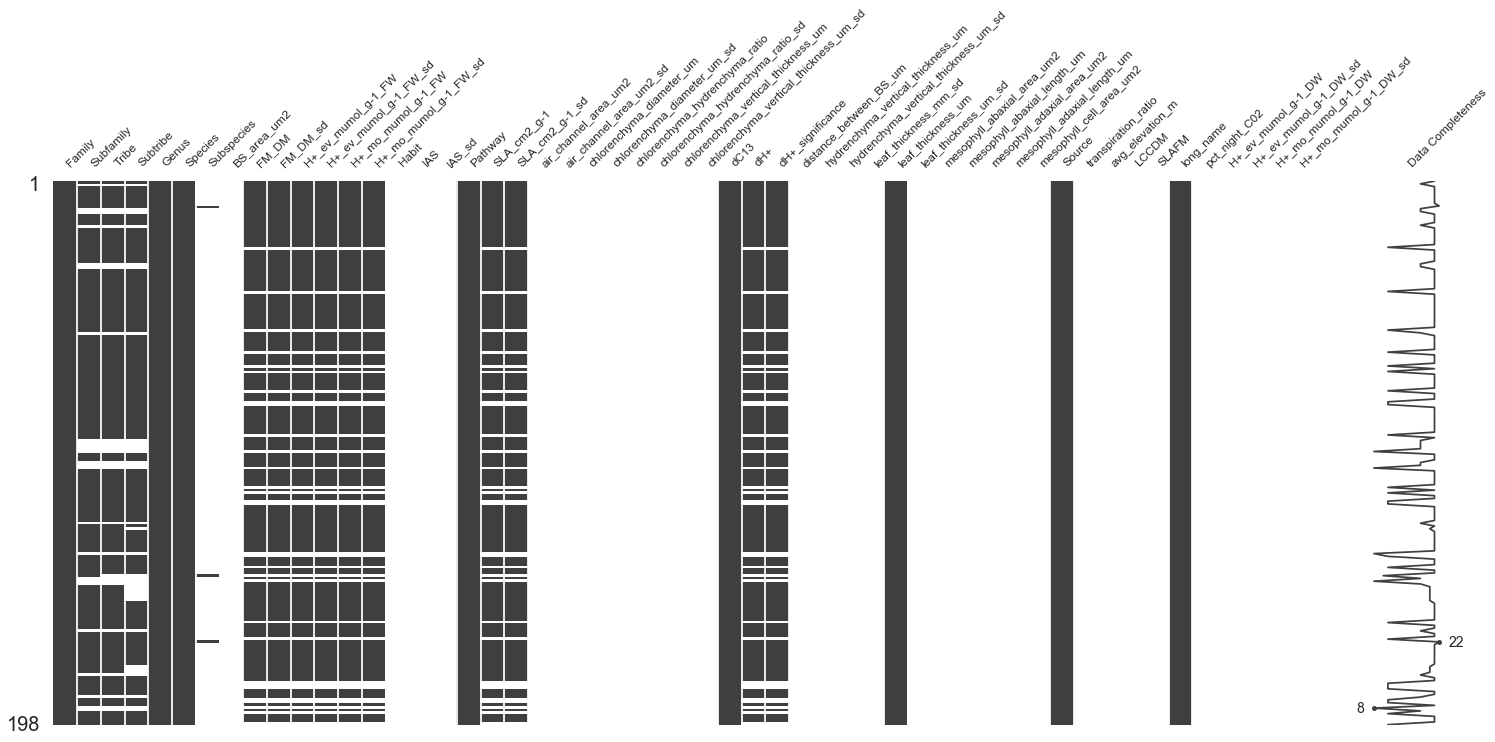

In [83]:
photo_db.db_info(orchid_2005, plt_missingdata=True, labels=True, fontsize=12)

In [84]:
orchid_features = ['FM_DM', 'SLA_cm2_g-1', 'leaf_thickness_um']
photo_db.db_info(orchid_2005[orchid_features+['Pathway', 'long_name']])

The CAM database consists of:
	198 observations,                                            
	None families,                                            
	None subfamiles,                                            
	None tribes,                                            
	None subtribes,                                            
	None genera, and                                            
	197 species from None publications.                                            
0.0626 of the data matrix is missing and                                            
198 observations have known photosynthetic pathways.


In [85]:
orchid_2005 = orchid_2005[orchid_features+['Pathway', 'long_name']]
orchid_2005.dropna(inplace=True)

After remove missing data we're left with 167 observations.

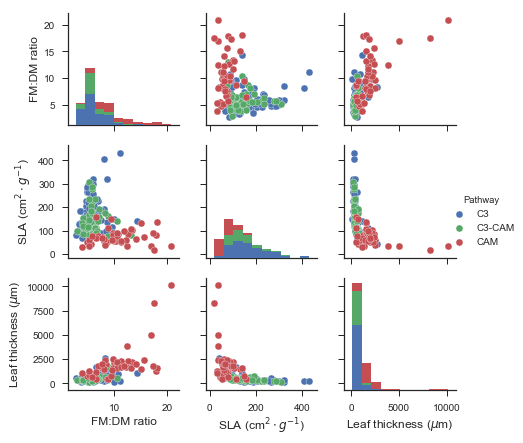

In [86]:
g = sns.pairplot(orchid_2005, hue="Pathway", markers='o')
g.fig.set_size_inches(7,6)
replacements = dict(zip(orchid_features ,['FM:DM ratio',
                                             'SLA (cm$^{2}\cdot g^{-1}$)',
                                             'Leaf thickness ($\mu$m)']))
for i in range(len(orchid_features)):
    for j in range(len(orchid_features)):
        xlabel = g.axes[i][j].get_xlabel()
        ylabel = g.axes[i][j].get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel], size=12)
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel], size=12)

In [87]:
logorchid_2005 = orchid_2005[orchid_features].apply(np.log)
logorchid_2005['Pathway'] = orchid_2005['Pathway']

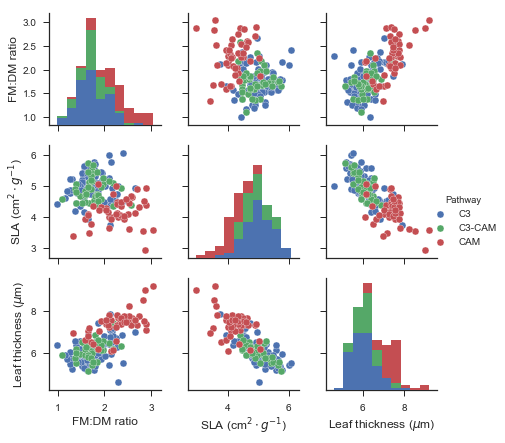

In [88]:
g = sns.pairplot(logorchid_2005, hue="Pathway", markers='o')
g.fig.set_size_inches(7,6)
replacements = dict(zip(orchid_features ,['FM:DM ratio',
                                          'SLA (cm$^{2}\cdot g^{-1}$)',
                                          'Leaf thickness ($\mu$m)']))
for i in range(len(orchid_features)):
    for j in range(len(orchid_features)):
        xlabel = g.axes[i][j].get_xlabel()
        ylabel = g.axes[i][j].get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel], size=12)
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel], size=12);

In [89]:
# Compute the correlation matrix
orchid_2005_corr = orchid_2005[orchid_features].corr()

# Generate a mask for the upper triangle
orchid_2005_mask = np.zeros_like(orchid_2005_corr, dtype=np.bool)
orchid_2005_mask[np.triu_indices_from(orchid_2005_mask)] = True

# Repeat for log-transformed
logorchid_2005_corr = logorchid_2005[orchid_features].corr()
logorchid_2005_mask = np.zeros_like(logorchid_2005_corr, dtype=np.bool)
logorchid_2005_mask[np.triu_indices_from(logorchid_2005_mask)] = True

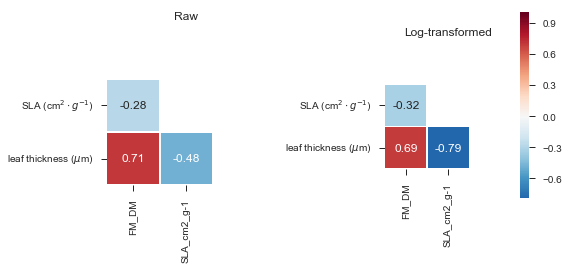

In [91]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(8, 4))

sns.heatmap(orchid_2005_corr, annot=True, mask=orchid_2005_mask, cmap="RdBu_r", center=0,
            square=True, linewidths=.5, cbar=False, ax=ax0)
sns.heatmap(logorchid_2005_corr, annot=True, mask=logorchid_2005_mask, cmap="RdBu_r", center=0,
            square=True, linewidths=.5, cbar=True, ax=ax1)

ax0.set_title('Raw')
ax0.set_xticks([0.5, 1.5,])
ax0.set_yticks([2.5, 1.5])
ax0.set_yticklabels(['leaf thickness ($\mu$m)', 'SLA (cm$^2\cdot g^{-1}$)'], va='center')

ax1.set_title('Log-transformed')
ax1.set_xticks([0.5, 1.5,])
ax1.set_yticks([2.5, 1.5])
ax1.set_yticklabels(['leaf thickness ($\mu$m)', 'SLA (cm$^2\cdot g^{-1}$)'], va='center')

plt.tight_layout();

In [92]:
orchid_pca_config = PCA(n_components=2)
orchid_temp = orchid_2005[orchid_features]
orchid_PCA = orchid_pca_config.fit(orchid_temp).transform(orchid_temp)
print('Raw explained variance (first two components): %s' % str(orchid_pca_config.explained_variance_ratio_))

logorchid_pca_config = PCA(n_components=2)
logorchid_temp = logorchid_2005[orchid_features]
logorchid_PCA = logorchid_pca_config.fit(logorchid_temp).transform(logorchid_temp)
print('Log-transformed explained variance (first two components): %s' % str(logorchid_pca_config.explained_variance_ratio_))

Raw explained variance (first two components): [ 0.99676533  0.00323061]
Log-transformed explained variance (first two components): [ 0.83818513  0.13227851]


As in the bromeliads, the amount of variance explained by the first two principal components is over 95%.

In [93]:
orchid_color_map = {'C3':'blue', 'C3-CAM':'green', 'CAM':'red'}

In [94]:
orchid_PCA_DF = pd.DataFrame(orchid_PCA, columns=['X', 'Y'])
orchid_PCA_DF['color'] = [orchid_color_map[pathway] for pathway in orchid_2005['Pathway']]

logorchid_PCA_DF = pd.DataFrame(logorchid_PCA, columns=['X', 'Y'])
logorchid_PCA_DF['color'] = [orchid_color_map[pathway] for pathway in logorchid_2005['Pathway']]

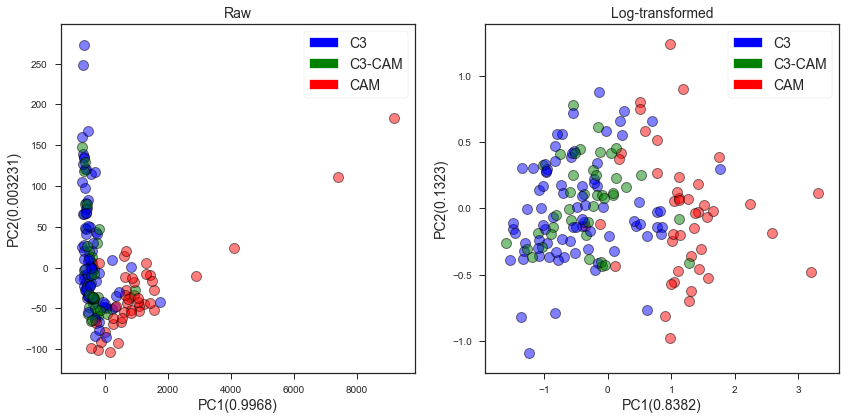

In [95]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))

for i in range(len(orchid_PCA_DF)):
    ax0.scatter(orchid_PCA_DF.iloc[i, 0], orchid_PCA_DF.iloc[i,1], alpha = 0.5,
                    c=orchid_PCA_DF['color'][i], edgecolors='black', linewidths=1, s=100)

for i in range(len(logorchid_PCA_DF)):
    ax1.scatter(logorchid_PCA_DF.iloc[i, 0], logorchid_PCA_DF.iloc[i,1], alpha = 0.5,
                    c=logorchid_PCA_DF['color'][i], edgecolors='black', linewidths=1, s=100)

ax0.set_xlabel("PC1("+str('{:.4}'.format(orchid_pca_config.explained_variance_ratio_[0]))+")", size=14)
ax0.set_ylabel("PC2("+str('{:.4}'.format(orchid_pca_config.explained_variance_ratio_[1]))+")", size=14)
ax1.set_xlabel("PC1("+str('{:.4}'.format(logorchid_pca_config.explained_variance_ratio_[0]))+")", size=14)
ax1.set_ylabel("PC2("+str('{:.4}'.format(logorchid_pca_config.explained_variance_ratio_[1]))+")", size=14)
    
red_patch = mpatches.Patch(color='red', label='CAM')
green_patch = mpatches.Patch(color='green', label='C3-CAM')
blue_patch = mpatches.Patch(color='blue', label='C3')

ax0.legend(handles=[blue_patch, green_patch, red_patch], fontsize=14, frameon=True,)
ax1.legend(handles=[blue_patch, green_patch, red_patch], fontsize=14, frameon=True)
ax0.set_title('Raw', size=14)
ax1.set_title('Log-transformed', size=14)

plt.tight_layout();

## Support vector machine
### raw data

In [372]:
# Uncomment to remove C3-CAM for testing 2-label classification
# orchid_2005 = orchid_2005.loc[orchid_2005['Pathway']!='C3-CAM']
# log_orchid_2005 = logorchid_2005.loc[logorchid_2005['Pathway']!='C3-CAM']

# Uncomment to remove C3 for testing 2-label classification
# orchid_2005 = orchid_2005.loc[orchid_2005['Pathway']!='C3']
# logorchid_2005 = logorchid_2005.loc[logorchid_2005['Pathway']!='C3']

#### A note on multi-class SVM
Support vector machines are inherently 2 class methods. There are two main ways we can get around this when we want to have multiple classes (e.g. C3, CAM, and C3-CAM): one-vs-one and one-vs-all classification. In one-vs-one we train a classifier for _each pair of classes_, while in one-vs-all we train a classifier for _each class against all other classes_. One-vs-one tends to handle imbalanced class sizes (as we have here; ~twice as many C3 as either CAM or C3-CAM), but comes at a larger computational cost. We'll use one-vs-one here, which is the default for `svm.SVC`, because the computational burden isn't so high and our data are fairly imbalanced. 

In [98]:
# Divide into training and testing data (X's) and responses (y's) 
orchid_train_X, orchid_test_X, orchid_train_y, orchid_test_y = train_test_split(
    orchid_2005[orchid_features], orchid_2005['Pathway'], test_size=0.25, random_state=0)

# Create and SVM classification object 
orchid_svm_clf = svm.SVC(kernel='linear')

In [99]:
orchid_svm_crossval = cross_val_score(orchid_svm_clf, orchid_2005[orchid_features], orchid_2005['Pathway'], 
                                      cv=5, n_jobs=-1)
orchid_svm_preds = cross_val_predict(orchid_svm_clf, orchid_2005[orchid_features], orchid_2005['Pathway'], 
                                     cv=5, n_jobs=-1)
orchid_svm_crosstab = pd.crosstab(orchid_2005['Pathway'], orchid_svm_preds, 
                                  rownames=['Actual'], colnames=['Predicted'])
print("Cross-validation accuracy: %0.3f (+/- %0.3f)" % (orchid_svm_crossval.mean(), orchid_svm_crossval.std()))
orchid_svm_crosstab

Cross-validation accuracy: 0.665 (+/- 0.054)


Predicted,C3,CAM
Actual,,
C3,74,8
C3-CAM,39,2
CAM,7,37


Our accuracy is pretty low, and we didn't predict a single observation to be C3-CAM&mdash;almost were classified as C3.

### log-transformed data

In [100]:
# Divide into training and testing data (X's) and responses (y's) 
logorchid_train_X, logorchid_test_X, logorchid_train_y, logorchid_test_y = train_test_split(
    logorchid_2005[orchid_features], logorchid_2005['Pathway'], test_size=0.25, random_state=0)

# Create and SVM classification object 
logorchid_svm_clf = svm.SVC(kernel='linear')

In [101]:
logorchid_svm_crossval = cross_val_score(logorchid_svm_clf, logorchid_2005[orchid_features],
                                         logorchid_2005['Pathway'], cv=5, n_jobs=-1)
logorchid_svm_preds = cross_val_predict(logorchid_svm_clf, logorchid_2005[orchid_features], 
                                     logorchid_2005['Pathway'], cv=5, n_jobs=-1)
logorchid_svm_crosstab = pd.crosstab(logorchid_2005['Pathway'], logorchid_svm_preds, 
                                  rownames=['Actual'], colnames=['Predicted'])
print("Cross-validation accuracy: %0.3f (+/- %0.3f)" % (logorchid_svm_crossval.mean(), 
                                                        logorchid_svm_crossval.std()))
logorchid_svm_crosstab

Cross-validation accuracy: 0.630 (+/- 0.063)


Predicted,C3,CAM
Actual,,
C3,69,13
C3-CAM,39,2
CAM,8,36


Neither of our SVMs are very good at classifying the three phenotypes. While there are most likely improvements we can make to the model and model fitting, with only 40-50 observations of each class we simply may not have enough power to classify these phenotypes.

Next we'll try random forests again, which _are_ inherently multi-class.

## Random forest

In [102]:
orchid_rf_clf = RandomForestClassifier(n_jobs=-1)
# Repeat cross validation as before
orchid_rf_crossval = cross_val_score(orchid_rf_clf, orchid_2005[orchid_features], orchid_2005['Pathway'], 
                                   cv=5, n_jobs=-1)
orchid_rf_preds = cross_val_predict(orchid_rf_clf, orchid_2005[orchid_features], orchid_2005['Pathway'], 
                                  cv=5, n_jobs=-1)
orchid_rf_crosstab = pd.crosstab(orchid_2005['Pathway'], orchid_rf_preds, rownames=['Actual'], colnames=['Predicted'])

print("Cross-validation accuracy: {:.3} (+/- {:.3})".format(orchid_rf_crossval.mean(), orchid_rf_crossval.std()))
orchid_rf_crosstab

Cross-validation accuracy: 0.63 (+/- 0.0842)


Predicted,C3,C3-CAM,CAM
Actual,,,
C3,60,15,7
C3-CAM,32,7,2
CAM,5,1,38


In [103]:
orchid_rf_importance = orchid_rf_clf.fit(orchid_train_X, orchid_train_y).feature_importances_
orchid_importance = pd.DataFrame(zip(orchid_train_X, orchid_rf_importance), columns=['feature', 'importance'])
orchid_importance.sort_values(by='importance', ascending=False)

,feature,importance
1,SLA_cm2_g-1,0.342524
0,FM_DM,0.330600
2,leaf_thickness_um,0.326876


In [104]:
logorchid_rf_clf = RandomForestClassifier(n_jobs=-1)
# Repeat cross validation as before
logorchid_rf_crossval = cross_val_score(logorchid_rf_clf, logorchid_2005[orchid_features], 
                                        logorchid_2005['Pathway'], cv=5, n_jobs=-1)
logorchid_rf_preds = cross_val_predict(logorchid_rf_clf, logorchid_2005[orchid_features], 
                                       logorchid_2005['Pathway'], cv=5, n_jobs=-1)
logorchid_rf_crosstab = pd.crosstab(logorchid_2005['Pathway'], logorchid_rf_preds, 
                                    rownames=['Actual'], colnames=['Predicted'])

print("Cross-validation accuracy: {:.3} (+/- {:.3})".format(logorchid_rf_crossval.mean(), 
                                                            logorchid_rf_crossval.std()))
logorchid_rf_crosstab

Cross-validation accuracy: 0.625 (+/- 0.074)


Predicted,C3,C3-CAM,CAM
Actual,,,
C3,56,20,6
C3-CAM,28,10,3
CAM,5,1,38


Our RF classifiers have increased training accuracy but about the same testing accuracy. This is symptomatic of a lack of data, specifically for training. We are able to build an accurate classifier during training but that classifier has not seen enough variation to reliably classify new points that it encounters during testing.